## ReAct Agent

In [1]:
## Create a workflow
import operator
from typing import List, TypedDict, Annotated, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq

## Load LLM model
model = 'deepseek-r1-distill-llama-70b'
llm = ChatGroq(model=model)

In [3]:
response = llm.invoke("what is the second longest wall after great wall of china. Is it in India? Give output in 5 line only")
print(response.content)

<think>
Okay, the user is asking about the second longest wall after the Great Wall of China and whether it's in India. They want the answer in five lines only. First, I need to confirm the actual second longest wall. I recall that the Great Wall of China is the longest, but I'm not entirely sure what's second. I think it's the Great Wall of Gorgan, also known as the Red Snake, in Iran. It's much shorter than the Great Wall of China but still significant. 

Now, the user is asking if it's in India. I know India has some historical structures, but none that are as long as the Great Wall of China or even the Great Wall of Gorgan. So the second longest isn't in India. I should make sure to mention that clearly. 

I should structure the answer to be concise, within five lines. Start by stating the second longest wall, its location, and then address the India part. Maybe mention that while India has many structures, none are the second longest. Keep it straightforward and informative withou

In [4]:
from langchain.tools import tool

In [5]:
@tool
def add(a:int,b:int) -> int:
    '''
    Add two integers
    
    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    '''
    pass

@tool
def multiply(a:int,b:int) -> int:
    '''
    Multiply two integers
    
    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    '''
    pass

@tool
def divide(a:int,b:int) -> float:
    '''
    divide two integers
    
    Args:
        a (int): The numerator.
        b (int): The denominator (must not be 0).
        
    Returns:
        float: The result of division.
    '''
    pass

## Import the inbuilt tool

In [6]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

In [7]:
search.invoke('What is latest updated on Air India Crash')

"Air India plane crash latest: Airline carrying out Boeing 787 safety checks as families reunited with victims Air India's Boeing 787 fleet could be grounded temporarily An Air India flight bound for London crashed shortly after taking off in the western city of Ahmedabad, killing all but one of the 242 people on board. Ahmedabad Plane Crash Updates:Investigators recovered the black box of the ill-fated Air India Boeing 787-8 Dreamliner (AI171) from the rooftop of a medical college hostel, a day after it crashed in Ahmedabad, killing 241 of the 242 on board. The Aircraft Accident Investigation Bureau confirmed the retrieval of the Digital Flight Data Recorder, key to understanding the crash. Following the ... The Air India flight fell from the sky on Thursday and killed at least 270 people in Gujarat state, officials said Saturday. All but one of the 242 people on board the London-bound flight died when it crashed into a residential area in Ahmedabad shortly after take-off."

In [7]:
## Tool list
tools_list = [multiply, add, divide, search]
## binding llm with tool
llm_with_tool = llm.bind_tools(tools_list)

In [8]:
response = llm_with_tool.invoke('Hi')
print(response.content)
print(response.tool_calls)

Hello! How can I assist you today? If you have any questions or need help with something, feel free to ask!
[]


In [9]:
response = llm_with_tool.invoke('what is 2+2')
print(response.content)
print(response.tool_calls)


[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': '4h1ec4z8x', 'type': 'tool_call'}]


In [10]:
response = llm_with_tool.invoke('What is the current age of TATA Group')
print(response.content)
print(response.tool_calls)


[{'name': 'duckduckgo_search', 'args': {'query': 'TATA Group founded year'}, 'id': '3taxxn45m', 'type': 'tool_call'}]


In [11]:
def function_1(state: MessagesState):
    return {'messages':[llm_with_tool.invoke(state['messages'])]}

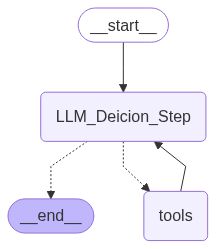

In [12]:
builder = StateGraph(MessagesState)
builder.add_node('LLM_Deicion_Step',function_1)
builder.add_node('tools', ToolNode(tools_list))
builder.add_edge(START, 'LLM_Deicion_Step')
builder.add_conditional_edges(
    'LLM_Deicion_Step',
    tools_condition
)
builder.add_edge('tools','LLM_Deicion_Step')
app = builder.compile()
app

In [13]:
message = [HumanMessage(content='Hi')]
app.invoke({'messages':message})

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='e95dabad-4adf-464d-a051-a2321b3b333e'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 388, 'total_tokens': 453, 'completion_time': 0.338333603, 'prompt_time': 0.025094585, 'queue_time': 0.22003719, 'total_time': 0.363428188}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--11169eb5-07da-441e-a31f-ee582e934f3c-0', usage_metadata={'input_tokens': 388, 'output_tokens': 65, 'total_tokens': 453})]}

In [14]:
message = [HumanMessage(content='what is 2+2')]
app.invoke({'messages':message})

{'messages': [HumanMessage(content='what is 2+2', additional_kwargs={}, response_metadata={}, id='3cae92a4-00ae-4a58-996a-bfe2e97f9cd0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '6sj0resem', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 274, 'prompt_tokens': 393, 'total_tokens': 667, 'completion_time': 1.043734562, 'prompt_time': 0.025445798, 'queue_time': 0.219490706, 'total_time': 1.06918036}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b9b78473-b8c8-48cb-8922-0510798fe42d-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': '6sj0resem', 'type': 'tool_call'}], usage_metadata={'input_tokens': 393, 'output_tokens': 274, 'total_tokens': 667}),
  ToolMessage(content='null', name='add', id='810530c4-cf9d-4f02-afd9-2f9e6a133432', tool_call_id='6sj0resem'),
  AIMess

In [15]:
SYSTEM_PROMPT = "You are a helpful assistant taked with using search and performing airthmetic operations on a set of inputs"

In [16]:
def function_1(state:MessagesState) :
    
    user_question = state['messages']
    print(user_question)
    input_question = [SYSTEM_PROMPT] + user_question
    print(input_question)
    
    response = llm_with_tool.invoke(input_question)
    
    return {'messages':[response]}

In [23]:
import operator
from typing import List, TypedDict, Annotated, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode

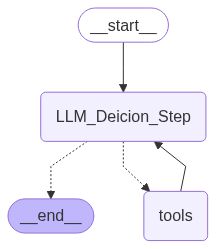

In [17]:

## Workflow
builder2 = StateGraph(MessagesState)
builder2.add_node('LLM_Deicion_Step',function_1)
builder2.add_node('tools', ToolNode(tools_list))
builder2.add_edge(START, 'LLM_Deicion_Step')
builder2.add_conditional_edges(
    'LLM_Deicion_Step',
    tools_condition
)
builder2.add_edge('tools','LLM_Deicion_Step')
app2 = builder.compile()
app2

In [18]:
llm_with_tool.invoke('What is the 2 times of narendra modi age')

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'secz5nkf7', 'function': {'arguments': '{"a":73,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 368, 'prompt_tokens': 399, 'total_tokens': 767, 'completion_time': 1.338181818, 'prompt_time': 0.025785346, 'queue_time': 0.21989324799999999, 'total_time': 1.363967164}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c9f05aaf-eeed-487a-9087-8e3ae19fb3c1-0', tool_calls=[{'name': 'multiply', 'args': {'a': 73, 'b': 2}, 'id': 'secz5nkf7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 399, 'output_tokens': 368, 'total_tokens': 767})

In [19]:
message = [HumanMessage(content='What is the 2 times of narendra modi age')]
app2.invoke({'messages':message})

{'messages': [HumanMessage(content='What is the 2 times of narendra modi age', additional_kwargs={}, response_metadata={}, id='7c24b94c-bca8-4778-8462-8ce8638e8c01'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'h4vzk8ds1', 'function': {'arguments': '{"query":"Narendra Modi age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 332, 'prompt_tokens': 399, 'total_tokens': 731, 'completion_time': 1.344096814, 'prompt_time': 0.032224979, 'queue_time': 0.220424939, 'total_time': 1.376321793}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--eac0ef91-50ad-4053-a207-022c37c798dd-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Narendra Modi age'}, 'id': 'h4vzk8ds1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 399, 'output_tokens': 332, 'total_tokens': 731}),
  ToolMessage(content='Narendra 

In [20]:
message = [HumanMessage(content="What is the speed of light in m/s and multiply it by 10?")]
response = app2.invoke({'messages':message})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the speed of light in m/s and multiply it by 10?
================================== Ai Message ==================================
Tool Calls:
  multiply (j27nqxyrr)
 Call ID: j27nqxyrr
  Args:
    a: 299792458
    b: 10
================================= Tool Message =================================
Name: multiply

null
================================== Ai Message ==================================
Tool Calls:
  multiply (2hseqw9na)
 Call ID: 2hseqw9na
  Args:
    a: 299792458
    b: 10
================================= Tool Message =================================
Name: multiply

null
================================== Ai Message ==================================
Tool Calls:
  multiply (hw8psh1m8)
 Call ID: hw8psh1m8
  Args:
    a: 299792458
    b: 10
================================= Tool Message =================================
Name: multiply

null
================================== Ai Mess

In [23]:
from langchain_openai import ChatOpenAI
import yfinance as yf

llm_openai = ChatOpenAI(model = 'o3-mini')

In [22]:
llm_openai.invoke('Hi')

AIMessage(content='Hello there! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 7, 'total_tokens': 94, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': 'fp_e20469f047', 'id': 'chatcmpl-BjIeFfi7tC7B8NyffCkX5CnlTcTSk', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--02a8fad3-3518-4097-a68c-1fd1d9a08a65-0', usage_metadata={'input_tokens': 7, 'output_tokens': 87, 'total_tokens': 94, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 64}})

In [ ]:
dat = yf.Ticker('MSFT')



474.96

In [28]:
@tool
def get_stock_price(ticker:str) -> str:
    '''
    Fetches the previous closing price of a given stock ticker from Yahoo Finance.
    
    Args:
        ticker (str) : The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO')
        
    Returns:
        str : A message with the stock's previous closing price
    '''
    
    try:
        stock = yf.Ticker(ticker)
        price = stock.info['previousClose']
        if price is None:
            return f'Could not fetch price for ticker {ticker}'
        return f'The last closing price of {ticker.upper()} was ${price:.2f}'
    except Exception as e:
        return f'An error occured while fetching the price : {e}'

In [29]:
get_stock_price('AAPL')

C:\Users\ashut\AppData\Local\Temp\ipykernel_37704\3955064537.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  get_stock_price('AAPL')


'The last closing price of AAPL was $196.45'

In [30]:
tools_list = [multiply, add, divide, search, get_stock_price]

openai_llm_with_tool= llm_openai.bind_tools(tools_list)

In [31]:
response = openai_llm_with_tool.invoke('what is the latest stock price for adani greens')

In [32]:
response.content

''

In [33]:
response.tool_calls

[{'name': 'get_stock_price',
  'args': {'ticker': 'ADANIGREEN'},
  'id': 'call_uOoIEvYxgCkgSlraK9NvZRzU',
  'type': 'tool_call'}]

In [34]:
SYSTEM_PROMPT = SystemMessage(
    content = 'You are a helpful financial assistant tasked with using the search, yahoo finance tool and performing airthmatic on a set of inputs.'
)

def function_tool(state:MessagesState):
    
    user_question = state['messages']
    
    input_question = [SYSTEM_PROMPT] + user_question
    
    response = openai_llm_with_tool.invoke(input_question)
    
    return {'messages': [response]}

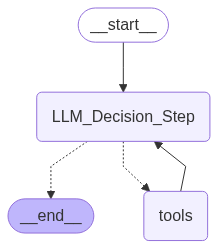

In [35]:
## grapgh
workflow = StateGraph(MessagesState)
workflow.add_node('LLM_Decision_Step', function_tool)
workflow.add_node('tools', ToolNode(tools_list))
workflow.add_edge(START,'LLM_Decision_Step')
workflow.add_conditional_edges(
    'LLM_Decision_Step',
    tools_condition
)
workflow.add_edge('tools','LLM_Decision_Step')
app3 = workflow.compile()
app3

In [36]:
message = [HumanMessage(content='add $1000 in current price of Apple')]
response = app3.invoke({'messages':message})

In [37]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

add $1000 in current price of Apple
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_lPjOdBLWIsuC9j63jGq3AjhP)
 Call ID: call_lPjOdBLWIsuC9j63jGq3AjhP
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $196.45
================================== Ai Message ==================================

The last closing price of Apple is $196.45. When you add $1000 to that, the total comes to $1,196.45.


In [40]:
message = [HumanMessage(content="can you give me 2 times of current stock price of Apple with the latest news of the Apple.")]
response = app3.invoke({'messages':message})

In [41]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

can you give me 2 times of current stock price of Apple with the latest news of the Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_FqN3ZBxrjtNEWcD4Nc3bFZh6)
 Call ID: call_FqN3ZBxrjtNEWcD4Nc3bFZh6
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $196.45
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_qsvKR9gku41S2ovTj9LbXyRY)
 Call ID: call_qsvKR9gku41S2ovTj9LbXyRY
  Args:
    query: Apple latest news
================================= Tool Message =================================
Name: duckduckgo_search

At today's WWDC 2025 keynote event, Apple unveiled a new design that will inform the next decade of iOS, iPadOS, and macOS development, so needl